# Repeating Every Assessment/Experiment With 2.5D Execution



##### <center> <i> <span style="color:green"> Before we start... </span> </i> </center>

As the title indicates, I'll be exploring results of using 2.5D classification, and comparing them with the replication of slices, in order to ascertain whether this approach is successful. 

Of course, these results will most likely be quite specific to my data set and methodologies, and will only represent a direct comparison and quality of my own methods.

In order to maintain consistent cross-analysis results contrasts, each experiment will retain its original train-test-validation split and ResNet setup (architecture, settings, etc.).

Additionally, I'll be avoiding some experimental comparisons, as they provided results that are guaranteed to be identical throughout both <span style="color:#2377c4"> 2D (represented in blue) </span> and <span style="color:orange"> 2.5D (represented in orange)</span> classification. For example, I will not be using HRCT as the test split, nor testing whether the pure or conservative approach is best for best epoch choice. 

Still, all of this implies several code replications and re-executions. For this reason, I chose to display results in the form of a small report, with indexes and numbered titles, in order to facilitate comprehension and analysis.

# Table of Contents

- [1. Data Augmentation vs No Augmentation](#1-data-augmentation-vs-no-augmentation)
  - [1.1 Concept Overview](#11-concept-overview)
  - [1.2 Data Augmentation vs No Augmentation](#13-25d-execution-of-data-augmentation-vs-no-augmentation)
    - <span style="color:#2377c4"> 2D execution </span>
    - <span style="color:orange"> 2.5D execution </span>

  - [1.3 Threshold Selection and Model Choice](#12-threshold-selection-and-model-choice)
  - [1.4 Comparison with 2D](#14-comparison-with-2d)

- [2. Patient-wise Classification Methods](#2-patient-wise-classification-methods)
  - [2.1 Concept Overview](#21-concept-overview)
  - [2.2 Patient-wise Classification Methods](#23-25d-execution-of-patient-wise-classification-methods)
    - <span style="color:#2377c4"> 2D execution </span>
    - <span style="color:orange"> 2.5D execution </span>
  - [2.3 Threshold Selection and Model Choice](#22-threshold-selection-and-model-choice)
  - [2.4 Comparison with 2D](#24-comparison-with-2d)

- [3. Slice-level Feature-wise Classification](#3-slice-level-feature-wise-classification)
  - [3.1 Concept Overview](#31-concept-overview)
  - [3.2 Slice-level Feature-wise Classification](#33-25d-execution-of-slice-level-feature-wise-classification)
    - <span style="color:#2377c4"> 2D execution </span>
    - <span style="color:orange"> 2.5D execution </span>
  - [3.3 Threshold Selection and Model Choice](#32-threshold-selection-and-model-choice)
  - [3.4 Comparison with 2D](#34-comparison-with-2d)

- [4. Conclusion](#4-conclusion)


<a name="1-data-augmentation-vs-no-augmentation"></a>
## 1. Data Augmentation vs No Augmentation

This section will be dedicated to assess whether the 2.5D model can outperform the 2D model. In order to do so, the first step is to run both resnets with the same configuration, architecture and data split. (only because the original ResNet was only trained for 50 epochs, and is therefore not directly comparable).


<a name="11-concept-overview"></a>
### 1.1 Concept Overview  

For detailed information on augmentations, please refer to directory `3 - resnetTesting`.



<a name="13-25d-execution-of-data-augmentation-vs-no-augmentation"></a>
### 1.2 Data Augmentation vs No Augmentation  


The dictionary below will be used to save relevant metadata and models, with structure:

```py

results_aug["method"] = [best_epoch, train_loss, best_val_loss, model]

```

In [123]:
results_aug = {}

In [124]:
from newDimUtils import *

import matplotlib.colors as mcolors

# Loads the dataframe
df_fibrosis = pd.read_pickle(r'..\..\..\\fibrosis_data.pkl')
df_annotations = df_fibrosis.drop(columns="SliceData")
df_annotations["SliceID"] = df_annotations["SliceID"].astype(str) + ".npy" # better for data loader
df_annotations.head()

,SliceID,Class
0,101__CT-0002-0001.npy,0
1,101__CT-0002-0002.npy,0
2,101__CT-0002-0003.npy,0
3,101__CT-0002-0004.npy,0
4,101__CT-0002-0005.npy,0


<center> 

#### <span style="color:#2377c4"> 2D, no Augmentations </span>

</center>

In [125]:
class FibrosisDataset(Dataset):
        def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
            self.img_labels = pd.read_csv(annotations_file)
            self.img_dir = img_dir
            self.transform = transform
            self.target_transform = target_transform
            self.albumentations = albumentations
            self.gauss = gauss
            self.number_images = 0

        def __len__(self):
            return len(self.img_labels)

        def __getitem__(self, idx):
            # idx represents index
            img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
            if not os.path.exists(img_path): print(f"Missing file: {img_path}")
            slice_id = self.img_labels.iloc[idx, 0]
            patient_id = getPatientID(slice_id)

            # Load the .npy file
            image = np.load(img_path)
            
            #image = read_image(img_path)
            label = self.img_labels.iloc[idx, 1]

            # Adds randomly selected gauss noise or blur
            if self.gauss:
                # Gaussian Noise
                gauss_noise = image + np.random.normal(loc=0, scale=random.choice(range(10,40)), size=image.shape)
                # Gaussian Blur
                gauss_blur = gaussian_filter(image, sigma=(random.choice(range(10,16))/10)) 
                # Random Choice
                image = random.choice((gauss_noise,gauss_blur))

            # Guarantee compatibility
            if self.gauss or self.albumentations: image = image.astype(np.float32)

            # Applies necessary ResNet input transformations
            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                label = self.target_transform(label)
            
            return image, label, patient_id

In [126]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=None, gauss=False)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

# Needed for classification
test_dataset_2d = test_dataset
val_dataset_2d = val_dataset

In [127]:
models_path = "..\\..\\..\\trainedResNets\\repeatingExperiment\\augNoAug\\2D\\"
os.makedirs(models_path, exist_ok=True)

#ans = str(input("Do you wish to run or read?"))
ans = "read"

# Choice execution
if ans == "run": 
    resnet_eval, best_epoch, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

elif ans == "read":
    # Read file
    checkpoint = torch.load(os.path.join(models_path,"metadata_Noaug2D.pt"))

    # Load values
    best_epoch = checkpoint["epoch"]
    custom_loss = checkpoint["train_loss"]
    custom_val_loss = checkpoint["val_loss"]

    resnet_eval = torch.load((f"{models_path}"+"resnet_noAug_2d.pkl"))


else: print("Invalid answer, try again.")

In [128]:
ans = str(input("Do you wish to save?"))

if ans == "yes": 
    torch.save({
    'epoch': best_epoch,
    'train_loss': custom_loss,
    'val_loss': custom_val_loss
}, os.path.join(models_path, 'metadata_Noaug2D.pt'))
    
    torch.save(resnet_eval, (f"{models_path}"+"resnet_noAug_2d.pkl"))

else: print("DID NOT SAVE")

DID NOT SAVE


In [129]:
# Save to dict for result comparison
results_aug["2d_noAug"] = [best_epoch, custom_loss, custom_val_loss, resnet_eval]

<center> 

#### <span style="color:#2377c4"> 2D, with Augmentations </span>

</center>

In [130]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])


# Augmentations
augment = A.Compose([
    # Applies resize prior to augmentations
    # Could hinder scan quality, but drastically improves training speed
    A.Resize(224, 224),
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

In [131]:
models_path = "..\\..\\..\\trainedResNets\\repeatingExperiment\\augNoAug\\2D\\"
os.makedirs(models_path, exist_ok=True)

#ans = str(input("Do you wish to run or read?"))
ans = "read"

# Choice execution
if ans == "run": 
    resnet_eval, best_epoch, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

elif ans == "read":
    # Read file
    checkpoint = torch.load(os.path.join(models_path,"metadata_aug2D.pt"))

    # Load values
    best_epoch = checkpoint["epoch"]
    custom_loss = checkpoint["train_loss"]
    custom_val_loss = checkpoint["val_loss"]

    resnet_eval = torch.load((f"{models_path}"+"resnet_Aug_2d.pkl"))


else: print("Invalid answer, try again.")

In [132]:
ans = str(input("Do you wish to save?"))

if ans == "yes": 
    torch.save({
    'epoch': best_epoch,
    'train_loss': custom_loss,
    'val_loss': custom_val_loss
}, os.path.join(models_path, 'metadata_aug2D.pt'))
    
    torch.save(resnet_eval, (f"{models_path}"+"resnet_Aug_2d.pkl"))

else: print("DID NOT SAVE")

DID NOT SAVE


In [133]:
# Save to dict for result comparison
results_aug["2d_Aug"] = [best_epoch, custom_loss, custom_val_loss, resnet_eval]

<center> 

#### <span style="color:orange"> 2.5D, no Augmentations </span>

</center>

In [134]:
class FibrosisDataset(Dataset):
        def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
            self.img_labels = pd.read_csv(annotations_file)
            self.img_dir = img_dir
            self.transform = transform
            self.target_transform = target_transform
            self.albumentations = albumentations
            self.gauss = gauss
            self.number_images = 0

        def __len__(self):
            return len(self.img_labels)
        

        def __getitem__(self, idx):
            # idx represents index

            # Locates each image in the csv file
            img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
            if not os.path.exists(img_path): print(f"Missing file: {img_path}")

            # Fetches entire slice name
            slice_id = self.img_labels.iloc[idx, 0]

            # Parses patient ID for each slice
            patient_id = getPatientID(slice_id)

            # Get current slice info and class
            curr_img = np.load(img_path)
            label = self.img_labels.iloc[idx, 1]


            # This function can fetch any additional slice
            def load_image(i):
                row = self.img_labels.iloc[i]
                path = os.path.join(self.img_dir, row[0])
                img = np.load(path).astype(np.float32)
                label = row[1]
                return img, label, row[0]

            
            # Fetches previous slice
            if (idx > 0) and getPatientID(self.img_labels.iloc[idx - 1, 0]) == patient_id:
                prev_img, _, _ = load_image(idx - 1)
            else: prev_img = curr_img  # Duplicates slice if it's the first, uses as previous 
            
            # Try to get next slice
            if (idx < len(self.img_labels) - 1) and getPatientID(self.img_labels.iloc[idx + 1, 0]) == patient_id:
                next_img, _, _ = load_image(idx + 1)
            else: next_img = curr_img  # Duplicates slice if it's the last, uses as next 
            

            # Finally, stacks them into RGB: shape → (3, H, W)
            image = np.stack([prev_img, curr_img, next_img], axis=0)

            # Reorder: shape → (H, W, 3)
            image = np.transpose(image, (1, 2, 0))  # Now it looks like an RGB image

            # Adds randomly selected gauss noise or blur
            if self.gauss:
                # Gaussian Noise
                gauss_noise = image + np.random.normal(loc=0, scale=random.choice(range(10,40)), size=image.shape)
                # Gaussian Blur
                gauss_blur = gaussian_filter(image, sigma=(random.choice(range(10,16))/10)) 
                # Random Choice
                image = random.choice((gauss_noise,gauss_blur))

            # Guarantee compatibility
            if self.gauss or self.albumentations: image = image.astype(np.float32)

            # Applies necessary ResNet input transformations
            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                label = self.target_transform(label)
            
            return image, label, patient_id

In [135]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
])

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=None, gauss=False)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

In [136]:
models_path = "..\\..\\..\\trainedResNets\\repeatingExperiment\\augNoAug\\2_5D\\"
os.makedirs(models_path, exist_ok=True)

#ans = str(input("Do you wish to run or read?"))
ans = "read"

# Choice execution
if ans == "run": 
    resnet_eval, best_epoch, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

elif ans == "read":
    # Read file
    checkpoint = torch.load(os.path.join(models_path,"metadata_Noaug2_5D.pt"))

    # Load values
    best_epoch = checkpoint["epoch"]
    custom_loss = checkpoint["train_loss"]
    custom_val_loss = checkpoint["val_loss"]

    resnet_eval = torch.load((f"{models_path}"+"resnet_noAug_2_5d.pkl"))


else: print("Invalid answer, try again.")

In [137]:
ans = str(input("Do you wish to save?"))

if ans == "yes": 
    torch.save({
    'epoch': best_epoch,
    'train_loss': custom_loss,
    'val_loss': custom_val_loss
}, os.path.join(models_path, 'metadata_Noaug2D.pt'))
    
    torch.save(resnet_eval, (f"{models_path}"+"resnet_noAug_2d.pkl"))

else: print("DID NOT SAVE")

DID NOT SAVE


In [138]:
results_aug["2_5d_noAug"] = [best_epoch, custom_loss, custom_val_loss, resnet_eval]

<center> 

#### <span style="color:orange"> 2.5D, with Augmentations </span>

</center>

In [139]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
])


# Augmentations
augment = A.Compose([
    # Applies resize prior to augmentations
    # Could hinder scan quality, but drastically improves training speed
    A.Resize(224, 224),
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

In [140]:
models_path = "..\\..\\..\\trainedResNets\\repeatingExperiment\\augNoAug\\2_5D\\"
os.makedirs(models_path, exist_ok=True)

#ans = str(input("Do you wish to run or read?"))
ans = "read"

# Choice execution
if ans == "run": 
    resnet_eval, best_epoch, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

elif ans == "read":
    # Read file
    checkpoint = torch.load(os.path.join(models_path,"metadata_aug2_5D.pt"))

    # Load values
    best_epoch = checkpoint["epoch"]
    custom_loss = checkpoint["train_loss"]
    custom_val_loss = checkpoint["val_loss"]

    resnet_eval = torch.load((f"{models_path}"+"resnet_Aug_2_5d.pkl"))


else: print("Invalid answer, try again.")

In [141]:
ans = str(input("Do you wish to save?"))

if ans == "yes": 
    torch.save({
    'epoch': best_epoch,
    'train_loss': custom_loss,
    'val_loss': custom_val_loss
}, os.path.join(models_path, 'metadata_aug2_5D.pt'))
    
    torch.save(resnet_eval, (f"{models_path}"+"resnet_Aug_2_5d.pkl"))

else: print("DID NOT SAVE")

DID NOT SAVE


In [142]:
# Save to dict for result comparison
results_aug["2_5d_Aug"] = [best_epoch, custom_loss, custom_val_loss, resnet_eval]

<a name="12-threshold-selection-and-model-choice"></a>
### 1.3 Threshold Selection and Model Choice  



In [143]:
def getAllROCs(results_dict, val_dataset):
    threshold_dict = {}
    all_rocs = {}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    subplot_positions = {}

    for key in results_dict:
        # Determine row
        if "2_5" in key:
            row = 1  
        else: 
            row = 0
            val_dataset = val_dataset_2d
        # Determine column
        col = 0 if ("no" in key or "No" in key) else 1
        subplot_positions[key] = (row, col)
    
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    for key, value in tqdm(results_dict.items()):
        model = value[3]
        model.to(device)
        model.eval()

        all_labels, all_scores = [], []

        with torch.no_grad():
            for images, labels, _ in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                probs = F.softmax(outputs, dim=1)[:, 1]

                all_scores.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
        roc_auc = auc(fpr, tpr)
        distances = np.sqrt((fpr) ** 2 + (1 - tpr) ** 2)
        best_idx = np.argmin(distances)
        best_threshold = thresholds[best_idx]

        threshold_dict[key] = best_threshold
        all_rocs[key] = (fpr, tpr, roc_auc, best_threshold, best_idx)

        # Subplot position
        row, col = subplot_positions[key]
        ax = axs[row][col]

        ax.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        ax.plot([0, 1], [0, 1], 'k--')
        ax.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Threshold = {best_threshold:.2f}')
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title(key)
        ax.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

    # Combined plot
    plt.figure(figsize=(8, 6))
    for key, (fpr, tpr, roc_auc, best_threshold, best_idx) in all_rocs.items():
        plt.plot(fpr, tpr, label=f'{key} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('All ROC Curves')
    plt.legend(loc='lower right')
    plt.show()

    return threshold_dict


In [144]:
def darken_color(color, factor=0.7):
    """Darken a color by a given factor (0 to 1)."""
    rgb = mcolors.to_rgb(color)
    return tuple(np.clip([c * factor for c in rgb], 0, 1))

def plotAllLossCurves(results_dict):
    num_models = len(results_dict)
    plt.figure(figsize=(12, 10))

    # Individual subplots (2 rows × 2 cols)
    for idx, (key, values) in enumerate(results_dict.items()):
        best_epoch = values[0]
        train_loss = values[1]
        val_loss = values[2]
        epochs = range(1, len(train_loss) + 1)
        best_val_loss = val_loss[best_epoch - 1]

        plt.subplot(2, 2, idx + 1)
        plt.plot(epochs, train_loss, label='Train Loss', linestyle='-', marker='o')
        plt.plot(epochs, val_loss, label='Val Loss', linestyle='--', marker='x')
        plt.plot(best_epoch, best_val_loss, 'X', color='purple', markersize=10, label='Best Epoch')

        plt.title(key)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

    # ----- Combined Plot -----
    plt.figure(figsize=(10, 6))

    # Use a predefined color cycle (can also use seaborn or matplotlib colormaps)
    color_cycle = plt.cm.tab10.colors  # 10 distinct colors
    keys = list(results_dict.keys())
    color_map = {key: color_cycle[i % len(color_cycle)] for i, key in enumerate(keys)}

    for key in keys:
        values = results_dict[key]
        best_epoch = values[0]
        train_loss = values[1]
        val_loss = values[2]
        epochs = range(1, len(train_loss) + 1)
        best_val_loss = val_loss[best_epoch - 1]

        base_color = color_map[key]
        darker_color = darken_color(base_color)

        # Plot both curves in the same color
        plt.plot(epochs, train_loss, color=base_color, linestyle='-', alpha=0.6)
        plt.plot(epochs, val_loss, color=base_color, linestyle='--', alpha=0.9)

        # Plot the 'best epoch' as a darker marker
        plt.plot(best_epoch, best_val_loss, 'X', color=darker_color, markersize=10)

    # Add single legend entry per method
    for key in keys:
        plt.plot([], [], color=color_map[key], label=key)

    plt.title('All Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


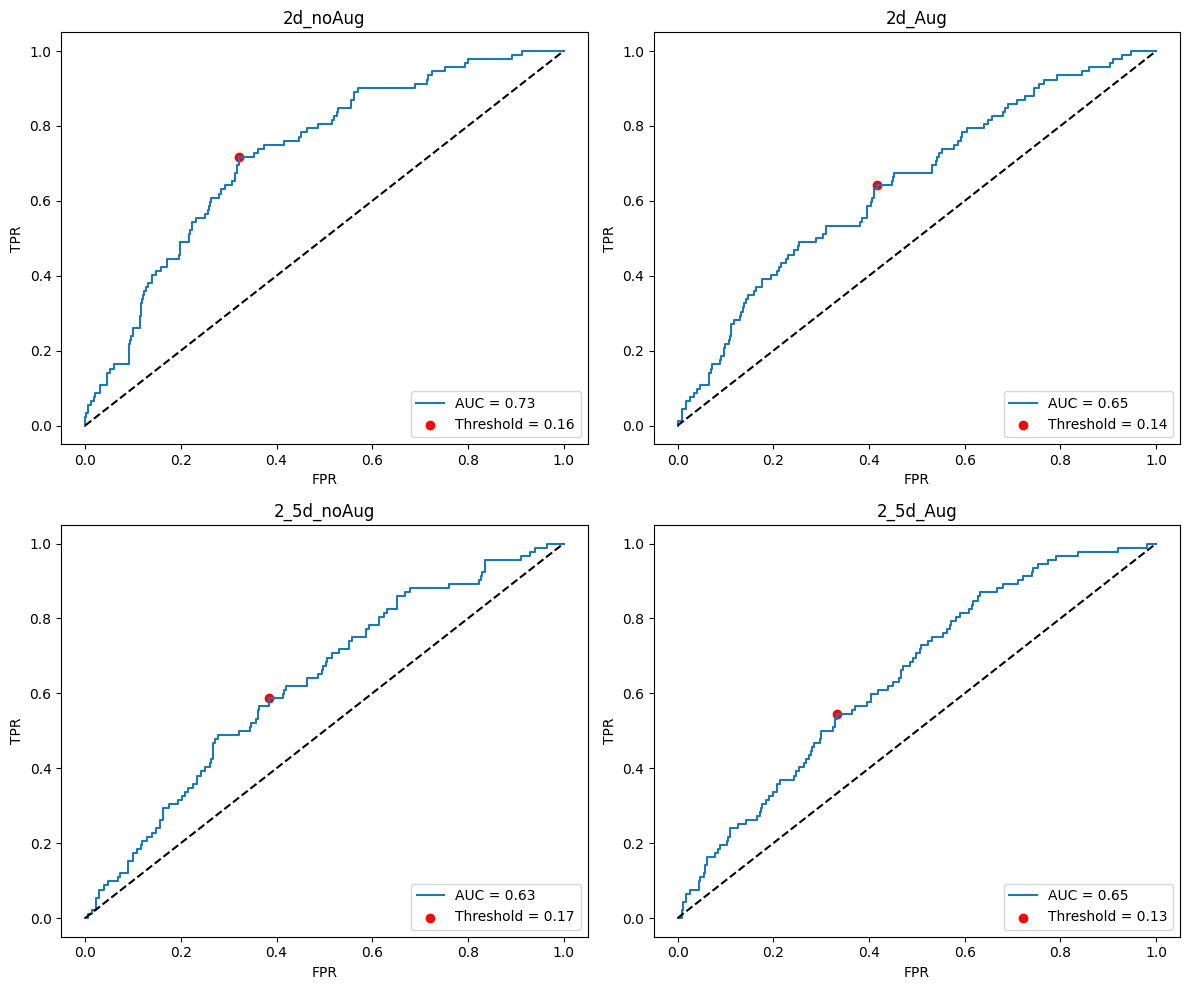

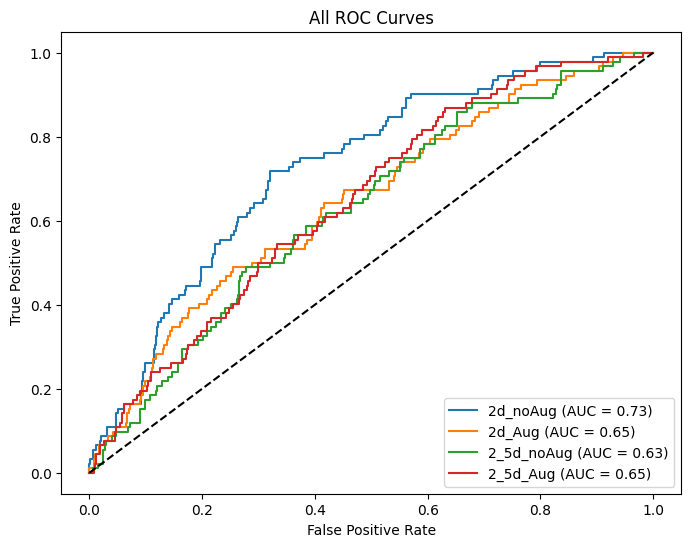

In [145]:
warnings.filterwarnings("ignore")

all_rocs = getAllROCs(results_aug, val_dataset)

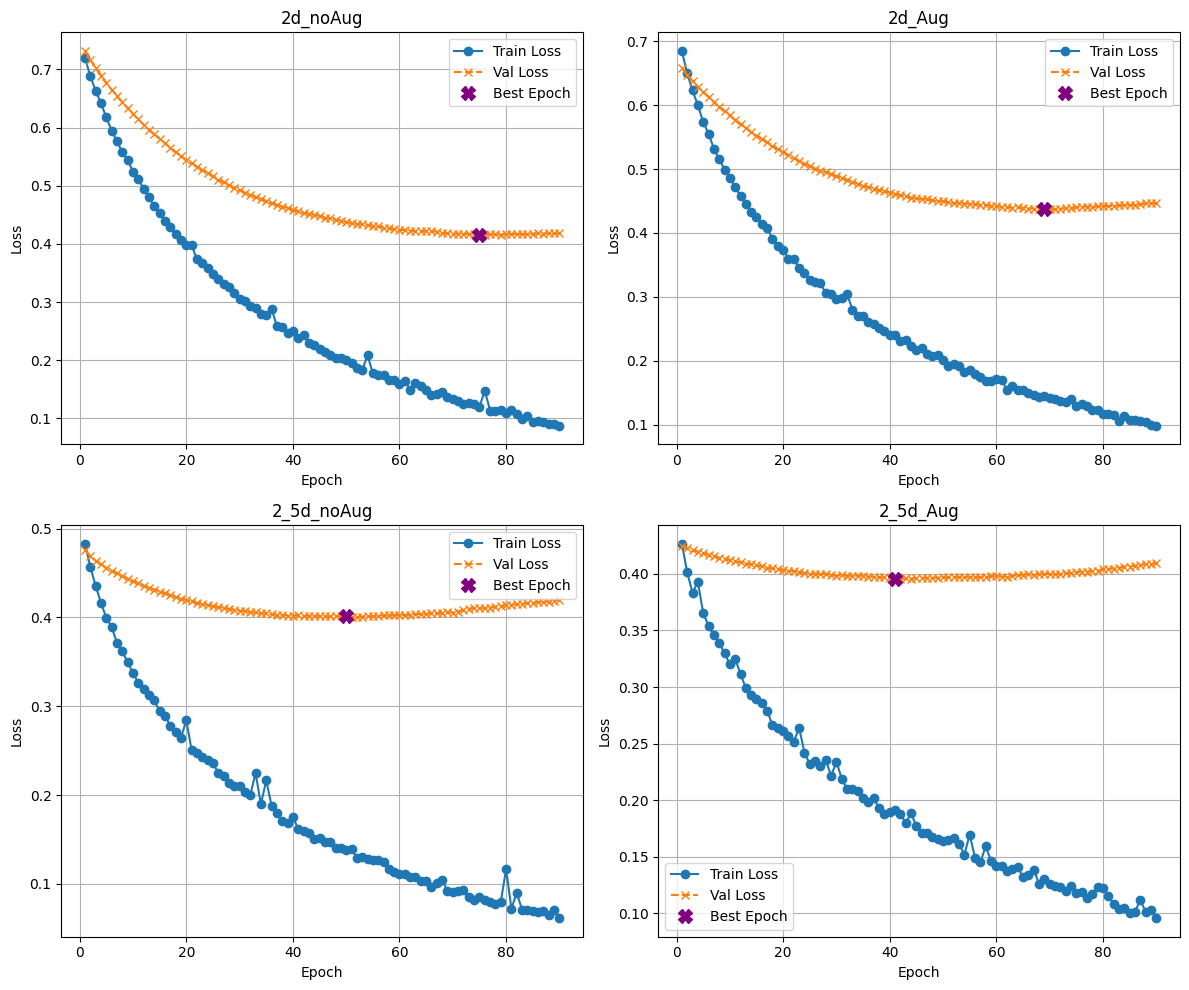

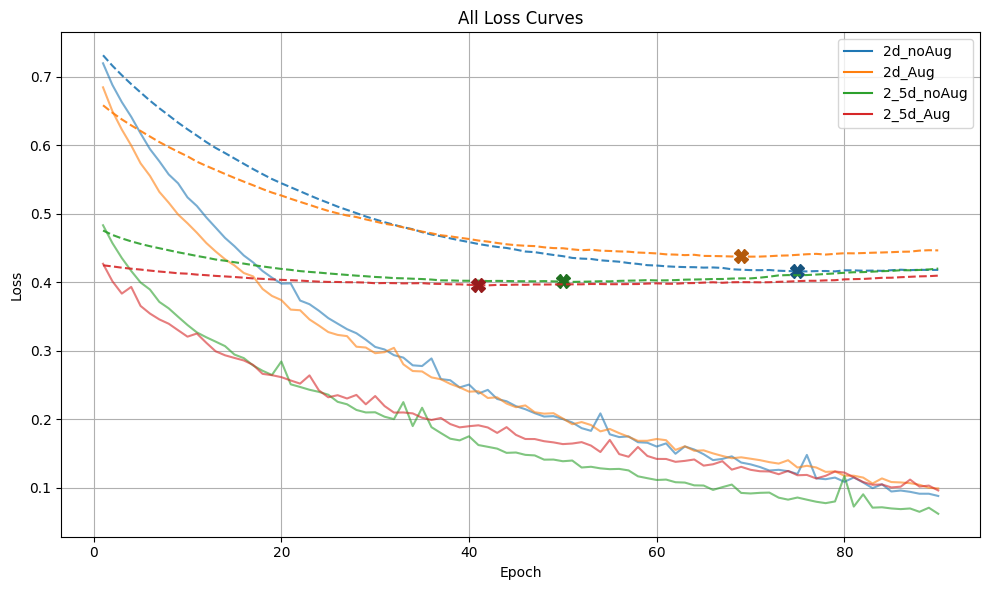

In [146]:
plotAllLossCurves(results_aug)


<a name="14-comparison-with-2d"></a>
### 1.4 Comparison with 2D  

In [147]:
metrics_aug = {}

for key, val in results_aug.items():
    print(f"               Method: {key}\n")
    if "_5" in key:
        m_aug = evalResNet(val[3], test_dataset, threshold=all_rocs[key])
    else: 
        m_aug = evalResNet(val[3], test_dataset_2d, threshold=all_rocs[key])
    metrics_aug[key] = m_aug
    print(" --------------------- \n")

               Method: 2d_noAug

Total examples: 648

 --------------------- 

Accuracy for Class 0: 53.64%  (302 in 563)
Accuracy for Class 1: 85.88%  (73 in 85)
Test Accuracy: 57.87%
Weighted Accuracy: 81.59%

 --------------------- 

F1 Score (Macro): 0.519
F1 Score (Weighted): 0.644
F1 Score Class 0: 0.689
F1 Score Class 1: 0.348

 --------------------- 


Confusion Matrix: 
 [[302 261]
 [ 12  73]]
 --------------------- 

               Method: 2d_Aug

Total examples: 648

 --------------------- 

Accuracy for Class 0: 52.75%  (297 in 563)
Accuracy for Class 1: 89.41%  (76 in 85)
Test Accuracy: 57.56%
Weighted Accuracy: 84.54%

 --------------------- 

F1 Score (Macro): 0.520
F1 Score (Weighted): 0.641
F1 Score Class 0: 0.684
F1 Score Class 1: 0.356

 --------------------- 


Confusion Matrix: 
 [[297 266]
 [  9  76]]
 --------------------- 

               Method: 2_5d_noAug

Total examples: 648

 --------------------- 

Accuracy for Class 0: 63.77%  (359 in 563)
Accuracy for Cla

---

<a name="2-patient-wise-classification-methods"></a>

## 2. Patient-wise Classification Methods




<a name="21-concept-overview"></a>
### 2.1 Concept Overview  

For detailed information on patient aggregation methods, please refer to directory `4.2 - evalAsPatient`.




<a name="23-25d-execution-of-patient-wise-classification-methods"></a>
### 2.2 Patient-wise Classification Methods  



In [209]:
results_patient = {}

<center> 

#### <span style="color:#2377c4"> 2D, Patient-Wise </span>

</center>

In [210]:
class FibrosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.albumentations = albumentations
        self.gauss = gauss

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # idx represents index
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        slice_id = self.img_labels.iloc[idx, 0]
        patient_id = getPatientID(slice_id)

        # Load the .npy file
        image = np.load(img_path)
        
        #image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        # Adds randomly selected gauss noise or blur
        if self.gauss:
            # Gaussian Noise
            gauss_noise = image + np.random.normal(loc=0, scale=random.choice(range(10,40)), size=image.shape)
            # Gaussian Blur
            gauss_blur = gaussian_filter(image, sigma=(random.choice(range(10,16))/10)) 
            # Random choice
            image = random.choice((gauss_noise,gauss_blur))

        # Guarantee compatibility
        if self.gauss or self.albumentations: image = image.astype(np.float32)

        # Applies necessary ResNet input transformations
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label, patient_id

In [211]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Augmentations
augment = A.Compose([
    # Applies resize prior to augmentations
    # Could hinder scan quality, but drastically improves training speed
    A.Resize(224, 224),
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

# Save for classification

test_dataset_patient = test_dataset
val_dataset_patient = val_dataset

In [212]:
models_path = "..\\..\\..\\trainedResNets\\aggregateProb\\"


# Read file
checkpoint = torch.load(os.path.join(models_path,"metadata.pt"))

# Load values
best_epoch = checkpoint["epoch"]
custom_loss = checkpoint["train_loss"]
custom_val_loss = checkpoint["val_loss"]

resnet_eval = torch.load((f"{models_path}"+"resnet_aggregate_correct_val.pkl"))

In [213]:
results_patient["2d"] = [best_epoch, custom_loss, custom_val_loss, resnet_eval]

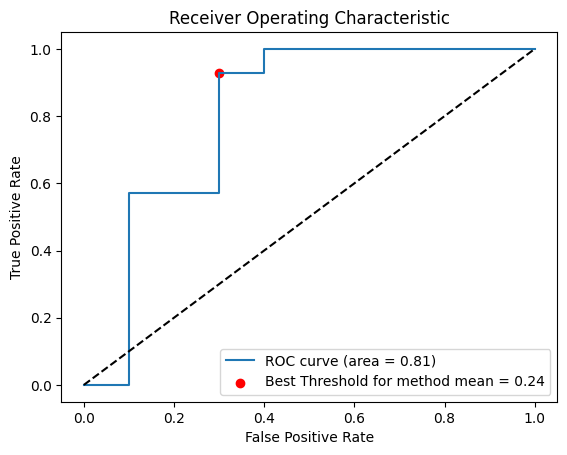

Area Under Curve: 0.8071428571428572
Best Threshold (closest to (0,1)): 0.23716810904443264


In [214]:
mean_thresh, mean_roc_auc = getROCAggregate(results_patient["2d"][3], test_dataset, 0.3493302, aggregate_criteria="mean")

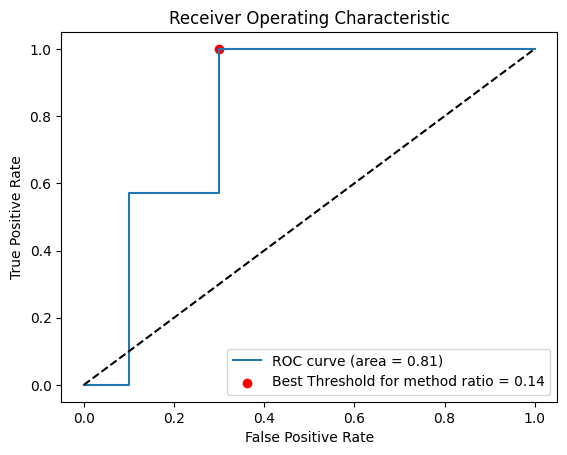

Area Under Curve: 0.8142857142857143
Best Threshold (closest to (0,1)): 0.13636363636363635


In [215]:
rat_thresh, rat_roc_auc = getROCAggregate(results_patient["2d"][3], test_dataset, 0.3493302, aggregate_criteria="ratio")

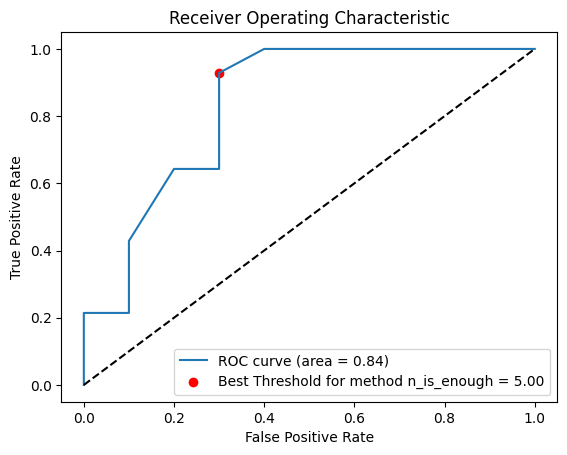

Area Under Curve: 0.8357142857142857
Best Threshold (closest to (0,1)): 5.0


In [216]:
n_thresh, n_roc_auc = getROCAggregate(results_patient["2d"][3], test_dataset, 0.3493302, aggregate_criteria="n_is_enough")

In [217]:
# Structure is mean, n_is_enough and ratio
thresholds_patient = {}
thresholds_patient["2d"] = [mean_thresh, n_thresh, rat_thresh]

<center> 

#### <span style="color:orange"> 2.5D, Patient-Wise </span>

</center>

In [218]:
class FibrosisDataset(Dataset):
        def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
            self.img_labels = pd.read_csv(annotations_file)
            self.img_dir = img_dir
            self.transform = transform
            self.target_transform = target_transform
            self.albumentations = albumentations
            self.gauss = gauss
            self.number_images = 0

        def __len__(self):
            return len(self.img_labels)
        

        def __getitem__(self, idx):
            # idx represents index

            # Locates each image in the csv file
            img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
            if not os.path.exists(img_path): print(f"Missing file: {img_path}")

            # Fetches entire slice name
            slice_id = self.img_labels.iloc[idx, 0]

            # Parses patient ID for each slice
            patient_id = getPatientID(slice_id)

            # Get current slice info and class
            curr_img = np.load(img_path)
            label = self.img_labels.iloc[idx, 1]


            # This function can fetch any additional slice
            def load_image(i):
                row = self.img_labels.iloc[i]
                path = os.path.join(self.img_dir, row[0])
                img = np.load(path).astype(np.float32)
                label = row[1]
                return img, label, row[0]

            
            # Fetches previous slice
            if (idx > 0) and getPatientID(self.img_labels.iloc[idx - 1, 0]) == patient_id:
                prev_img, _, _ = load_image(idx - 1)
            else: prev_img = curr_img  # Duplicates slice if it's the first, uses as previous 
            
            # Try to get next slice
            if (idx < len(self.img_labels) - 1) and getPatientID(self.img_labels.iloc[idx + 1, 0]) == patient_id:
                next_img, _, _ = load_image(idx + 1)
            else: next_img = curr_img  # Duplicates slice if it's the last, uses as next 
            

            # Finally, stacks them into RGB: shape → (3, H, W)
            image = np.stack([prev_img, curr_img, next_img], axis=0)

            # Reorder: shape → (H, W, 3)
            image = np.transpose(image, (1, 2, 0))  # Now it looks like an RGB image

            # Adds randomly selected gauss noise or blur
            if self.gauss:
                # Gaussian Noise
                gauss_noise = image + np.random.normal(loc=0, scale=random.choice(range(10,40)), size=image.shape)
                # Gaussian Blur
                gauss_blur = gaussian_filter(image, sigma=(random.choice(range(10,16))/10)) 
                # Random Choice
                image = random.choice((gauss_noise,gauss_blur))

            # Guarantee compatibility
            if self.gauss or self.albumentations: image = image.astype(np.float32)

            # Applies necessary ResNet input transformations
            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                label = self.target_transform(label)
            
            return image, label, patient_id

In [219]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
])


# Augmentations
augment = A.Compose([
    # Applies resize prior to augmentations
    # Could hinder scan quality, but drastically improves training speed
    A.Resize(224, 224),
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

No need to run model again. I'll simply be using the 2.5D Augmentation model.

In [220]:
results_patient["2_5d"] = results_aug["2_5d_Aug"]



<a name="22-threshold-selection-and-model-choice"></a>
### 2.3 Threshold Selection and Model Choice  



           Mean



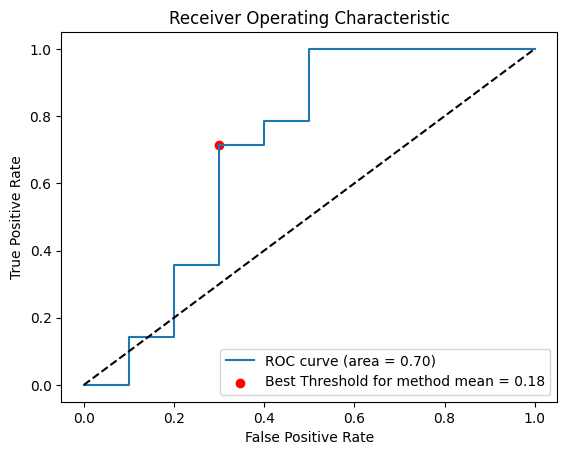

Area Under Curve: 0.7
Best Threshold (closest to (0,1)): 0.18488744677354893

 --------------------- 

           Ratio



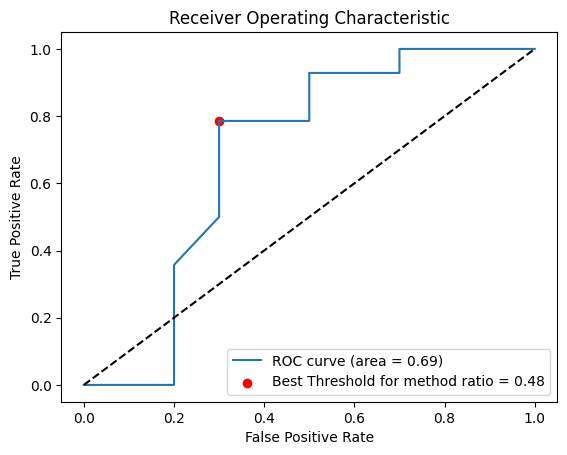

Area Under Curve: 0.6857142857142857
Best Threshold (closest to (0,1)): 0.48148148148148145

 --------------------- 

           N_is_enough



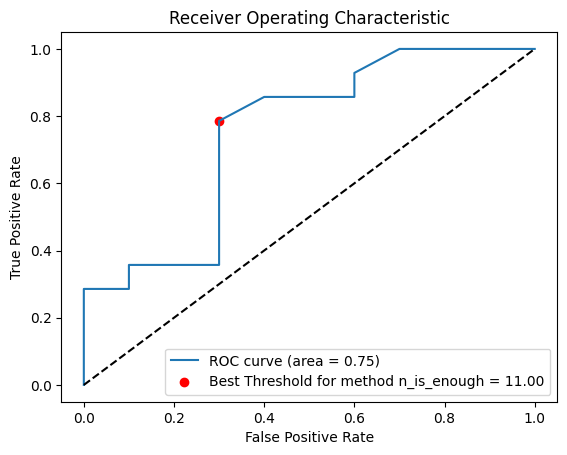

Area Under Curve: 0.75
Best Threshold (closest to (0,1)): 11.0


In [221]:
threshold_eval = all_rocs["2_5d_Aug"]
resnet_eval = results_aug["2_5d_Aug"][3]

print("           Mean\n")
mean_thresh, mean_roc_auc = getROCAggregate(resnet_eval, test_dataset, threshold_eval, aggregate_criteria="mean")
print("\n --------------------- \n")

print("           Ratio\n")
rat_thresh, rat_roc_auc = getROCAggregate(resnet_eval, test_dataset, threshold_eval, aggregate_criteria="ratio")
print("\n --------------------- \n")

print("           N_is_enough\n")
n_thresh, n_roc_auc = getROCAggregate(resnet_eval, test_dataset, threshold_eval, aggregate_criteria="n_is_enough")

In [222]:
thresholds_patient["2_5d"] = [mean_thresh, n_thresh, rat_thresh]


<a name="24-comparison-with-2d"></a>
### 2.4 Comparison with 2D  


In [229]:
metrics_patient = {}

#### Mean

In [230]:
for key, val in results_patient.items():
    print(f"               Method: {key}\n")
    if "_5" in key:
        m_patient = evalPatientProbResNet(val[3], test_dataset, threshold=thresholds_patient[key][0])
    else:
        m_patient = evalPatientProbResNet(val[3], test_dataset_patient, threshold=thresholds_patient[key][0])
    metrics_patient[key] = [m_patient]
    print(" --------------------- \n")

               Method: 2d

Total examples: 24
Labels:     [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]

 --------------------- 

Accuracy for Class 0: 70.00%  (7 in 10)
Accuracy for Class 1: 92.86%  (13 in 14)
Test Accuracy: 83.33%
Weighted Accuracy: 79.52%

 --------------------- 

F1 Score (Macro): 0.822
F1 Score (Weighted): 0.830
F1 Score Class 0: 0.778
F1 Score Class 1: 0.867

 --------------------- 


Confusion Matrix: 
 [[ 7  3]
 [ 1 13]]
 --------------------- 

               Method: 2_5d

Total examples: 24
Labels:     [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]

 --------------------- 

Accuracy for Class 0: 70.00%  (7 in 10)
Accuracy for Class 1: 71.43%  (10 in 14)
Test Accuracy: 70.83%
Weighted Accuracy: 70.60%

 --------------------- 

F1 Score (Macr

#### Absolute Value Tests 

In [231]:
for key, val in results_patient.items():
    print(f"               Method: {key}\n")
    if "_5" in key:
        m_patient = evalPatientProbResNet(val[3], test_dataset, threshold=all_rocs["2_5d_Aug"], aggregate_criteria="n_is_enough",
                                          n=thresholds_patient[key][1])
    else:
        m_patient = evalPatientProbResNet(val[3], test_dataset_patient, threshold=0.3493302, aggregate_criteria="n_is_enough",
                                          n=thresholds_patient[key][1])
    metrics_patient[key].append(m_patient)
    print(" --------------------- \n")

               Method: 2d

Total examples: 24
Labels:     [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

 --------------------- 

Accuracy for Class 0: 70.00%  (7 in 10)
Accuracy for Class 1: 92.86%  (13 in 14)
Test Accuracy: 83.33%
Weighted Accuracy: 79.52%

 --------------------- 

F1 Score (Macro): 0.822
F1 Score (Weighted): 0.830
F1 Score Class 0: 0.778
F1 Score Class 1: 0.867

 --------------------- 


Confusion Matrix: 
 [[ 7  3]
 [ 1 13]]
 --------------------- 

               Method: 2_5d

Total examples: 24
Labels:     [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]

 --------------------- 

Accuracy for Class 0: 70.00%  (7 in 10)
Accuracy for Class 1: 78.57%  (11 in 14)
Test Accuracy: 75.00%
Weighted Accuracy: 73.57%

 --------------------- 

F1 Score (Macr

#### Relative Value Tests

In [232]:
for key, val in results_patient.items():
    print(f"               Method: {key}\n")
    if "_5" in key:
        m_patient = evalPatientProbResNet(val[3], test_dataset, threshold=all_rocs["2_5d_Aug"], aggregate_criteria="ratio",
                                          ratio=thresholds_patient[key][2])
    else:
        m_patient = evalPatientProbResNet(val[3], test_dataset_patient, threshold=0.3493302, aggregate_criteria="ratio",
                                          ratio=thresholds_patient[key][2])
    metrics_patient[key].append(m_patient)
    print(" --------------------- \n")

               Method: 2d

Total examples: 24
Labels:     [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

 --------------------- 

Accuracy for Class 0: 70.00%  (7 in 10)
Accuracy for Class 1: 100.00%  (14 in 14)
Test Accuracy: 87.50%
Weighted Accuracy: 82.50%

 --------------------- 

F1 Score (Macro): 0.863
F1 Score (Weighted): 0.870
F1 Score Class 0: 0.824
F1 Score Class 1: 0.903

 --------------------- 


Confusion Matrix: 
 [[ 7  3]
 [ 0 14]]
 --------------------- 

               Method: 2_5d

Total examples: 24
Labels:     [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Predicted:  [0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]

 --------------------- 

Accuracy for Class 0: 70.00%  (7 in 10)
Accuracy for Class 1: 78.57%  (11 in 14)
Test Accuracy: 75.00%
Weighted Accuracy: 73.57%

 --------------------- 

F1 Score (Mac

---

<a name="3-slice-level-feature-wise-classification"></a>
## 3. Slice-level Feature-wise Classification




<a name="31-concept-overview"></a>
### 3.1 Concept Overview  

<a name="33-25d-execution-of-slice-level-feature-wise-classification"></a>
### 3.2 Slice-level Feature-wise Classification  


<center> 

#### <span style="color:orange"> 2.5D Feature Extraction </span>

</center>

In [34]:
features, labels, test_features, test_labels = getFeatures(resnet_eval, train_dataset, val_dataset, test_dataset)

Populating test features...: 100%|██████████| 21/21 [00:02<00:00,  7.06it/s]


In [35]:
print(len(features), "slices of shape",(features[0]).shape,"for training + validation")
print(len(test_features),"slices of shape", test_features[0].shape, "for test")

2427 slices of shape torch.Size([512, 1, 1]) for training + validation
648 slices of shape torch.Size([512, 1, 1]) for test


In [37]:
features_reshaped, test_reshaped = [], []

# Each ftr is now (512,)
[features_reshaped.append(ftr.squeeze(-1).squeeze(-1)) for ftr in features] 
[test_reshaped.append(ftr.squeeze(-1).squeeze(-1)) for ftr in test_features] 

# For visualization purposes
print('--------------------------------------------------------------')
print("Number of slices with derived features: ", len(features_reshaped))
print("Number of total train + validation slices: ", len(train_dataset) + len(val_dataset))
print("Slice features shape: ",features_reshaped[0].shape)
print("First 5 feature values for the first slice: \n    ", features_reshaped[0][:5])
print('--------------------------------------------------------------')
print("Number of test slices with derived features: ", len(test_reshaped))
print("Number of total test slices: ", len(test_dataset))
print("Slice features shape: ",test_reshaped[0].shape)
print("First 5 feature values for the first slice: \n    ", test_reshaped[0][:5])
print('--------------------------------------------------------------')

--------------------------------------------------------------
Number of slices with derived features:  2427
Number of total train + validation slices:  2427
Slice features shape:  torch.Size([512])
First 5 feature values for the first slice: 
     tensor([1.0371, 0.0963, 0.3957, 1.4691, 1.2463])
--------------------------------------------------------------
Number of test slices with derived features:  648
Number of total test slices:  648
Slice features shape:  torch.Size([512])
First 5 feature values for the first slice: 
     tensor([1.2729, 0.0706, 0.0138, 1.9882, 1.1652])
--------------------------------------------------------------


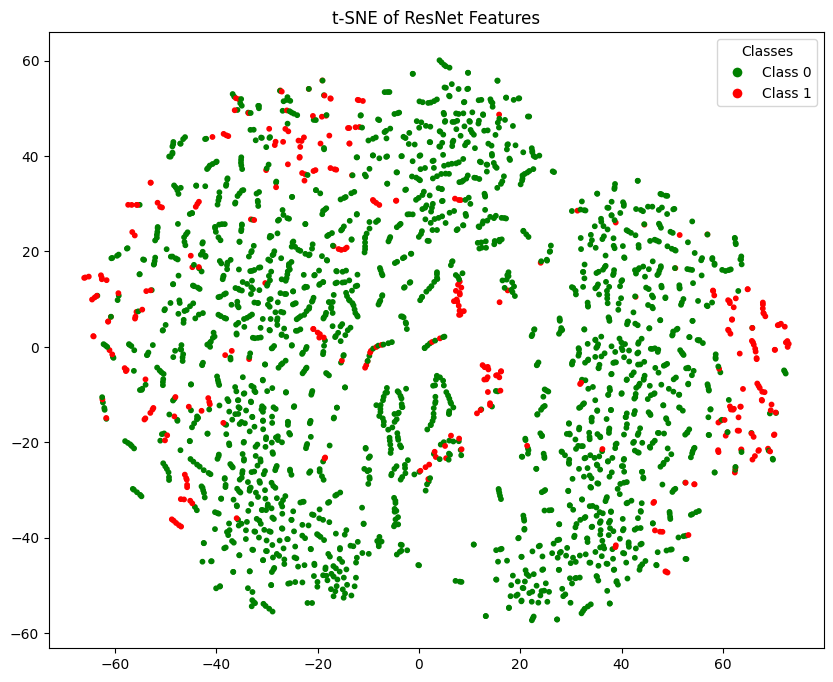

In [38]:
plotTSNE(features_reshaped, labels)

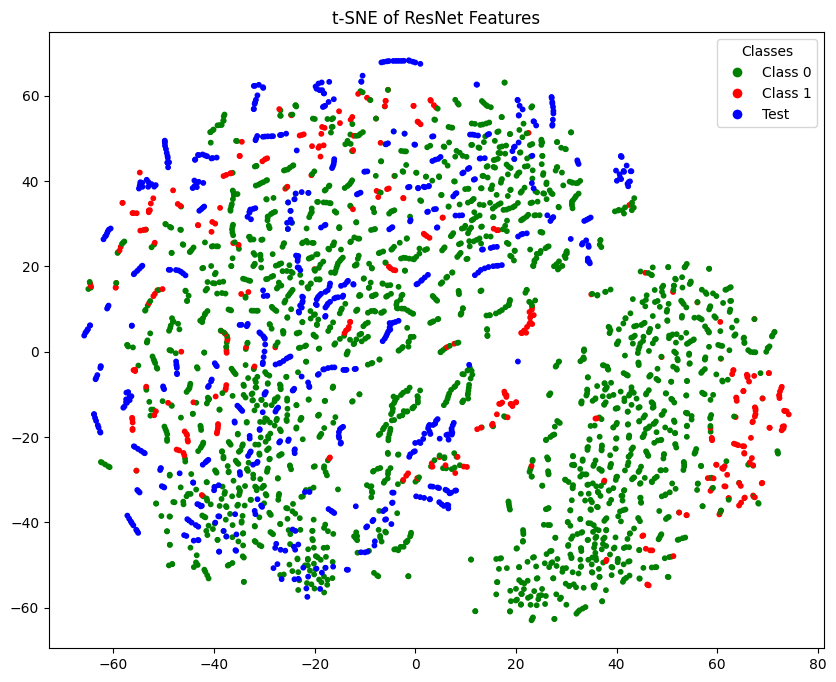

In [40]:
plotTSNE(features_reshaped, labels, test_features)

#### EXTRAS: Manifestation Plots

In [ ]:
# Setup
root = r"..\\..\\..\\fibrosis_dataset\ILD_DB_txtROIs"
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

train_ds = pd.read_csv(annotations_file_train)
val_ds = pd.read_csv(annotations_file_val)

manifest_dict = searchDiffManifest(root,verbose=0)

full_df = pd.concat([train_ds, val_ds], ignore_index=True)

manifest_df = manifestationDataframe(manifest_dict, full_df)

In [ ]:
plotTSNEManifest(train_val_features=features_reshaped, 
                 train_val_labels=labels,
                 test_features=False, 
                 full_df=full_df, manifest_df=manifest_df, 
                 apply_pca=False)




<a name="32-threshold-selection-and-model-choice"></a>
### 3.3 Threshold Selection and Model Choice  




#### Euclidean Performance

Testing for best k...: 100%|██████████| 512/512 [04:40<00:00,  1.82it/s]


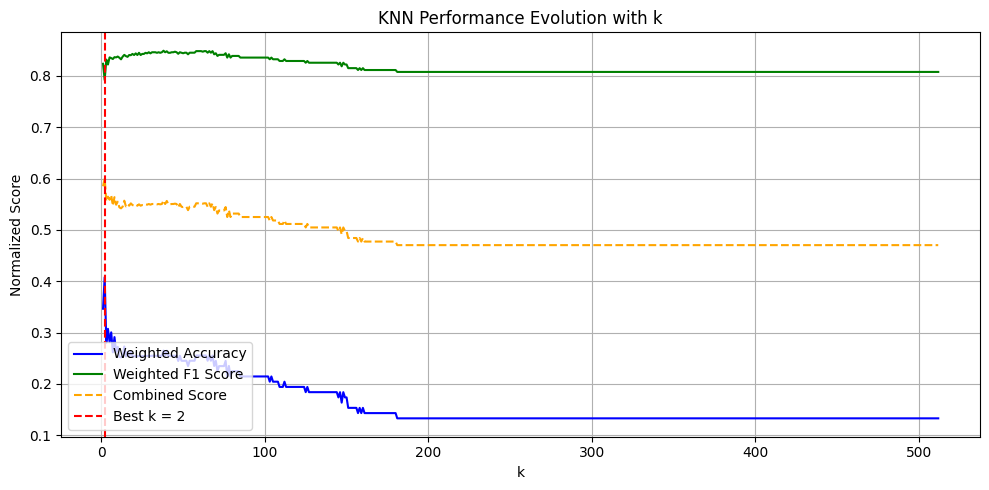

In [41]:
k_list_euclid, w_acc_list_euclid, w_f1_list_euclid = [], [], []
for i in tqdm(range(1,513), desc= "Testing for best k..."):
    k_i, weighted_acc_i, weighted_f1_i = featuresKNN_GPU(features_reshaped, labels, test_reshaped, test_labels,criteria="euclidean",k=i,verbose=0)
    k_list_euclid.append(k_i)
    w_acc_list_euclid.append(weighted_acc_i)
    w_f1_list_euclid.append(weighted_f1_i)

distanceCriteriaEvolution(k_list_euclid, w_acc_list_euclid, w_f1_list_euclid)

In [42]:
print("                            Eucliean Distance Performance for k=2                            ")
featuresKNN_GPU(features_reshaped, labels, test_reshaped, test_labels,criteria="euclidean",k=2)

                            Eucliean Distance Performance for k=2                            

 --------------------- 

Accuracy for Class 0: 84.37%  (475 in 563)
Accuracy for Class 1: 34.12%  (29 in 85)
Test Accuracy: 77.78%
Weighted Accuracy: 40.80%

 --------------------- 

F1 Score (Macro): 0.578
F1 Score (Weighted): 0.792
F1 Score Class 0: 0.868
F1 Score Class 1: 0.287

 --------------------- 


Confusion Matrix: 
 [[475  88]
 [ 56  29]]


#### Cosine Performance

Testing for best k...: 100%|██████████| 512/512 [04:38<00:00,  1.84it/s]


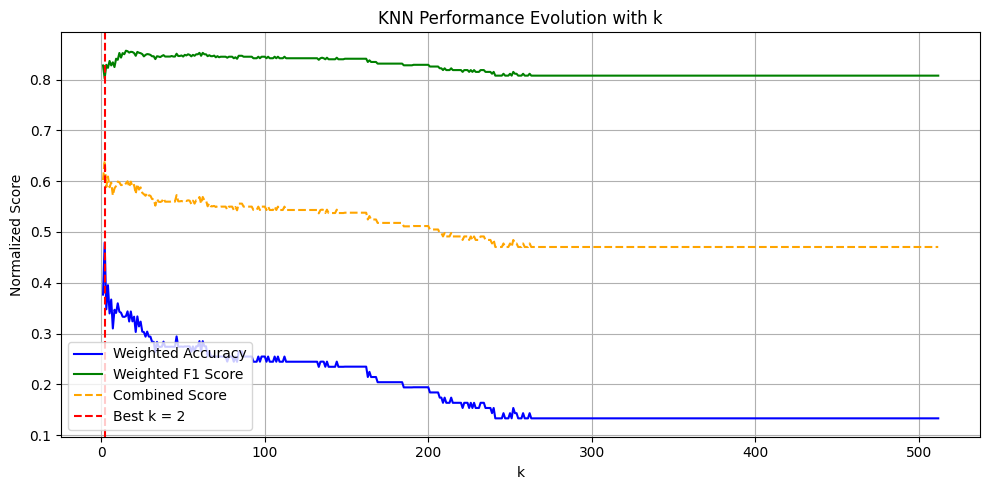

In [43]:
k_list_cosine, w_acc_list_cosine, w_f1_list_cosine = [], [], []
for i in tqdm(range(1,513), desc= "Testing for best k..."):
    k_i, weighted_acc_i, weighted_f1_i = featuresKNN_GPU(features_reshaped, labels, test_reshaped, test_labels, criteria="cosine",k=i,verbose=0)
    k_list_cosine.append(k_i)
    w_acc_list_cosine.append(weighted_acc_i)
    w_f1_list_cosine.append(weighted_f1_i)

distanceCriteriaEvolution(k_list_cosine, w_acc_list_cosine, w_f1_list_cosine)

In [44]:
print("                            Cosine Distance Performance for k=8                            ")
featuresKNN_GPU(features_reshaped, labels, test_reshaped, test_labels,criteria="cosine",k=8)

                            Cosine Distance Performance for k=8                            

 --------------------- 

Accuracy for Class 0: 92.01%  (518 in 563)
Accuracy for Class 1: 25.88%  (22 in 85)
Test Accuracy: 83.33%
Weighted Accuracy: 34.68%

 --------------------- 

F1 Score (Macro): 0.598
F1 Score (Weighted): 0.825
F1 Score Class 0: 0.906
F1 Score Class 1: 0.289

 --------------------- 


Confusion Matrix: 
 [[518  45]
 [ 63  22]]


#### Mahalanobis Performance

In [45]:
featuresKNN_CPU(features_reshaped, labels, test_reshaped, test_labels,criteria="mahalanobis")

Length of class1: 324


Computing mahalanobis distances... : 100%|██████████| 648/648 [01:17<00:00,  8.41it/s]

Total examples: 648

 --------------------- 

Accuracy for Class 0: 93.25%  (525 in 563)
Accuracy for Class 1: 28.24%  (24 in 85)
Test Accuracy: 84.72%
Weighted Accuracy: 36.88%

 --------------------- 

F1 Score (Macro): 0.620
F1 Score (Weighted): 0.837
F1 Score Class 0: 0.914
F1 Score Class 1: 0.327

 --------------------- 


Confusion Matrix: 
 [[525  38]
 [ 61  24]]



<a name="34-comparison-with-2d"></a>
### 3.4 Comparison with 2D  


---

<a name="4-conclusion"></a>

## 4. Conclusion 


The metrics dictionaries follow the structure below:

```py

metrics_topic[method] = [accuracy_class_0, accuracy_class_1, accuracy, weighted_accuracy,
                         f1_macro, f1_weighted, f1_class_0, f1_class_1, conf_mat] 

```

For simplicity of result analysis, I decided to create side-by-side barplots for 2D vs 2.5D:

In [ ]:
# Auxiliary function, helps creating 2 barplots in 1 plot
def plotGroup(group_dict, title, subplot_index, metric_labels):
    methods = list(group_dict.keys())
    values = [group_dict[m][:8] for m in methods]  # Exclude conf_mat
    num_metrics = len(metric_labels)
    x = np.arange(num_metrics)

    width = 0.8 / len(methods)  # Dynamic bar width

    plt.subplot(2, 1, subplot_index)
    for i, (method, vals) in enumerate(zip(methods, values)):
        # Choose color based on method name
        #color = 'red' if '_5' in method else '#2377c4'
        plt.bar(x + i * width, vals, width=width, label=method) #, color=color)

    plt.xticks(x + width * (len(methods) - 1) / 2, metric_labels, rotation=45)
    plt.ylabel("Score")
    plt.title(title)
    plt.legend()

    

def barPlotAug(metrics_dict):
    # Define metric labels (excluding conf_mat for plotting)
    metric_labels = [
        "Class 0 \nAccuracy", "Class 1 \nAccuracy", "Accuracy", "Weighted \nAccuracy",
        "F1 Macro", "F1 Weighted", "F1 Class 0", "F1 Class 1"
    ]
    
    if len(metrics_dict.keys()) > 2:
        # Split methods into 'no' and 'others'
        methods_with_no = {k: v for k, v in metrics_dict.items() if "no" in k.lower()}
        methods_others = {k: v for k, v in metrics_dict.items() if "no" not in k.lower()}
        
        
        plt.figure(figsize=(12, 10))

        if methods_with_no:
            method_keys = list(methods_with_no.keys())
            plotGroup(
                methods_with_no,
                f"{method_keys[0]} vs {method_keys[1]}",
                1,
                metric_labels
            )

        if methods_others:
            method_keys = list(methods_others.keys())
            plotGroup(
                methods_others,
                f"{method_keys[0]} vs {method_keys[1]}",
                2 if methods_with_no else 1,
                metric_labels
            )    


        plt.tight_layout()
        plt.show()

<center> 

### Augmentations

</center>

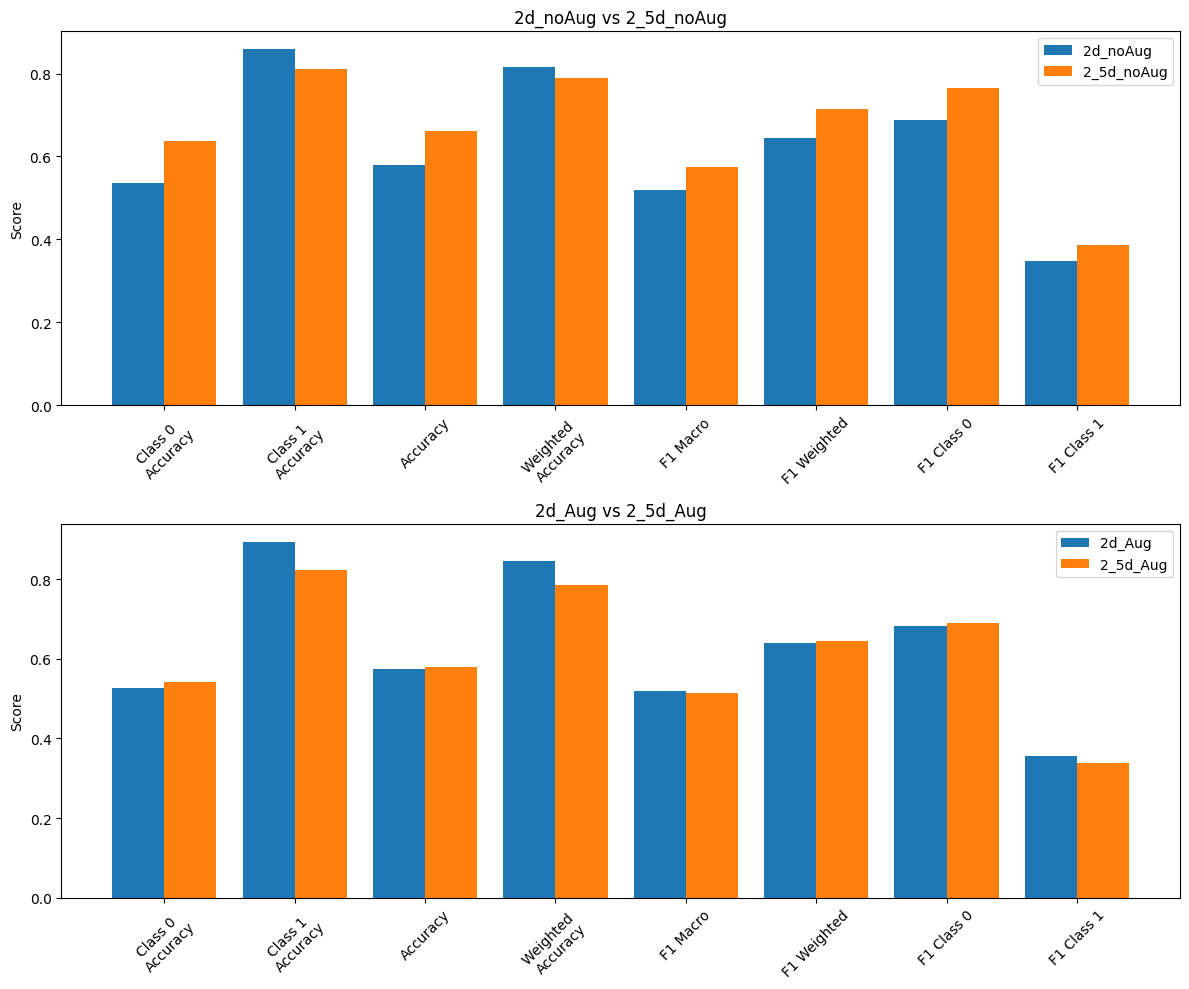

In [262]:
barPlotAug(metrics_aug)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 9) + inhomogeneous part.

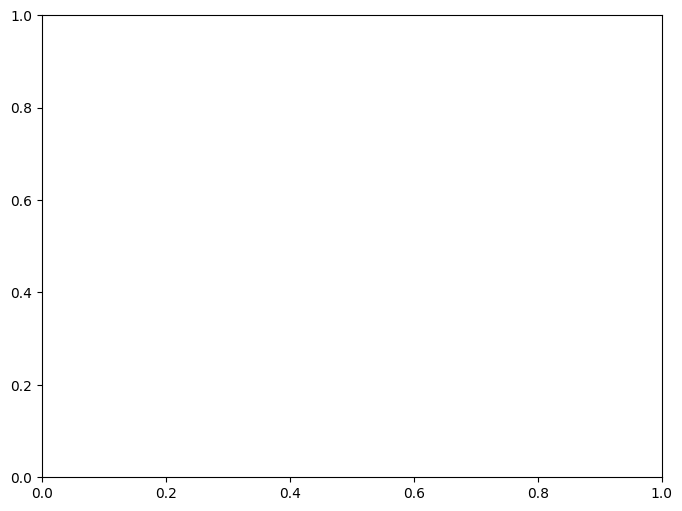

In [258]:
barPlotCollection(metrics_patient)